<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Online%20Retail_cltv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
!pip install plotly
!pip install Lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=27c1a4750cf9a5eb46a88185f862ca7e9ba13af2eda262f2c36f823042807834
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [99]:
import os
import warnings
import pandas as pd 
import numpy as np
import datetime as dt

import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
from lifetimes.plotting import plot_period_transactions
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
warnings.filterwarnings('ignore')

In [76]:
from google.colab import files
uploaded = files.upload()

Saving Online_Retail.xlsx to Online_Retail (2).xlsx


In [103]:
df = pd.read_excel(io.BytesIO(uploaded.get('Online_Retail.xlsx'))) #reading the excel file#

In [104]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [105]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'#'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'#'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'#'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'#'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'#'))
    print(dataframe.isnull().sum())
    print(" QUANTILES ".center(70,'#'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

############################### SHAPE ################################
Rows: 541909
Columns: 8
############################### TYPES ################################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
CustomerID            float64
Country                object
dtype: object
################################ HEAD ################################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  CustomerID         Country  
0 2010-12-01 08:26:00   2.55 

In [163]:
world_map = df[['CustomerID', 'Invoice', 'Country']].groupby(['CustomerID', 'Invoice', 'Country']).count()
world_map = world_map.reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Plasma',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution=50,
                         showocean=True,
                         oceancolor="LightBlue",
                          showland=True,
                         landcolor="Gray",
                         showframe = True),
             template = 'plotly_white')

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

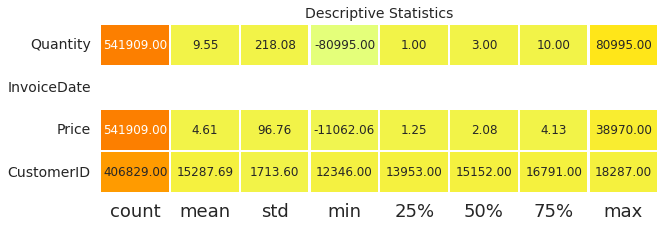

In [108]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot=True,
                cmap = "Wistia",
                fmt= '.2f',
                ax=ax,
                linecolor='white',
                linewidths = 1.3,
                cbar = False,
                annot_kws={"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df[[col for col in df.columns if df[col].dtype != 'O']])

In [109]:
df.dropna(inplace=True)
print('Missing Values: {}'.format(df.isnull().sum().sum()))

Missing Values: 0


In [111]:
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

In [113]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

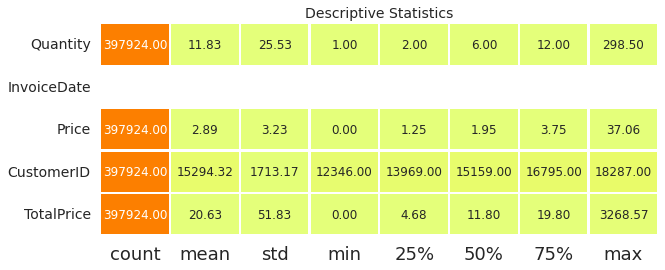

In [115]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

desc_stats(df[[col for col in df.columns if df[col].dtype != 'O']])

RFM Estimation - (Recency, Frequency, Monetary)

In [116]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [122]:
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda invoice_date: (today_date - invoice_date.max()).days,
                                    'Invoice': lambda invoice: invoice.nunique(),
                                    'TotalPrice': lambda total_price: total_price.sum()})

rfm.columns = ['recency','frequency','monetary']
#rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,310.44
1,12347.0,3,7,4310.00
2,12348.0,76,4,1770.78
3,12349.0,19,1,1491.72
4,12350.0,311,1,331.46


In [123]:
rfm['recency_score'] = pd.qcut(rfm['recency'],5,labels=[5,4,3,2,1])

rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method="first"),5,labels=[1,2,3,4,5])

rfm['monetary_score'] = pd.qcut(rfm['monetary'],5,labels=[1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str)+ rfm['frequency_score'].astype(str))

In [124]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,326,1,310.44,1,1,2,11,hibernating
1,12347.0,3,7,4310.00,5,5,5,55,champions
2,12348.0,76,4,1770.78,2,4,4,24,at_Risk
3,12349.0,19,1,1491.72,4,1,4,41,promising
4,12350.0,311,1,331.46,1,1,2,11,hibernating


In [125]:
rfm[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

recency                         monetary  \
                           mean        std min  max         mean   
segment                                                            
about_to_sleep        53.312500  10.943474  34   72   469.058097   
at_Risk              153.785835  68.618828  73  374   938.458341   
cant_loose           132.968254  65.250378  73  373  2646.822540   
champions              6.361769   3.683300   1   13  6498.612978   
hibernating          217.605042  92.013560  73  374   398.573036   
loyal_customers       33.608059  15.577050  15   72  2752.519574   
need_attention        52.427807  11.552074  34   72   847.657086   
new_customers          7.428571   3.902112   1   13   314.883690   
potential_loyalists   17.398760   9.338808   1   33   674.628357   
promising             23.421053   5.238115  15   33   282.617158   

                                                       frequency             \
                              std     min         max       mean        std   
segment                                                                       
about_to_sleep         533.161343    6.20    6207.670   1.161932   0.368913   
at_Risk                943.170824   52.00   11072.670   2.878583   0.954415   
cant_loose            2008.352354   70.02   10254.180   8.380952   4.289630   
champions            18366.105822  198.23  266163.525  12.417062  16.476484   
hibernating            553.714975    3.75    9182.345   1.101774   0.302492   
loyal_customers       5405.787839   36.56  120210.355   6.479853   4.545669   
need_attention         732.298552    6.90    4353.830   2.326203   0.470081   
new_customers          174.620952   89.94     848.550   1.000000   0.000000   
potential_loyalists    601.746293   20.80    4628.750   2.010331   0.651401   
promising              224.363976    0.00    1491.720   1.000000   0.000000   

                              
                    min  max  
segment                       
about_to_sleep        1    2  
at_Risk               2    6  
cant_loose            6   34  
champions             3  210  
hibernating           1    2  
loyal_customers       3   63  
need_attention        2    3  
new_customers         1    1  
potential_loyalists   1    3  
promising             1    1

In [127]:
data = go.Bar(y = pd.DataFrame(rfm['segment'].value_counts()).index,
              x = pd.DataFrame(rfm['segment'].value_counts())['segment'].values,
              name = str(pd.DataFrame(rfm['segment'].value_counts())['segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by Segments",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1300])
iplot(fig)

In [128]:
fig = go.Figure()
for i in rfm['segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['segment']==i]['recency'],
                           y=rfm[rfm['segment']==i]['frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  legend=dict(x=0.8,
                              y=1,
                              bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show()

In [129]:
kmeans_data = rfm.loc[:,['recency_score','frequency_score']]

inertia=[]
k = [1,2,3,4,5,6,7,8,9]
for i in k:
    kmean=KMeans(n_clusters=i)
    kmean.fit(kmeans_data)
    inertia.append(kmean.inertia_)
    
data = go.Scatter(x=k, y=inertia,mode='lines+markers',marker=dict(size=10))

layout = go.Layout(title={'text': "Elbow Method",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   width=650,
                   height=470,
                   xaxis = dict(title='Number of Clusters'),
                   yaxis =dict(title='Sum of Squared Distance'),
                   template = 'plotly_white')

fig =go.Figure(data=data,layout=layout)
iplot(fig)

Silhouette **Score**

In [130]:
kmeans = KMeans(n_clusters = 3,random_state = 42)
kmeans.fit(kmeans_data)
print('Silhouette Score: {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_),3)))

Silhouette Score: 0.447


In [131]:
rfm['k_means_segment'] = kmeans.labels_
rfm['k_means_segment'] = rfm['k_means_segment'].astype(str)
rfm[['recency','monetary','frequency','k_means_segment']].groupby('k_means_segment').agg({'mean','std','max','min'})

recency                         monetary                \
                       mean        std min  max         mean           std   
k_means_segment                                                              
0                 34.996445  40.345734   1  373  4006.879230  12028.095604   
1                204.631120  89.267019  73  374   506.003181    691.845251   
2                 34.075862  20.364312   1   72   595.012237    597.341799   

                                   frequency                      
                   min         max      mean        std min  max  
k_means_segment                                                   
0                36.56  266163.525  8.514810  11.060743   3  210  
1                 3.75   11072.670  1.481556   0.748261   1    5  
2                 0.00    6207.670  1.684483   0.708947   1    3

In [132]:
data = go.Bar(y = pd.DataFrame(rfm['k_means_segment'].value_counts()).index,
              x = pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values,
              name = str(pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values),
              orientation='h')

layout = go.Layout(title={'text': "Number of Customer by K-Means Segments",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis =dict(title='Customers'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_xaxes(range=[0,1900])
iplot(fig)

In [133]:
fig = make_subplots(rows=2,cols=3)

fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['recency'],showlegend=False,
                     name = '0',marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['recency'],showlegend=False,
                     name = '1',marker_color='#EB1919'),row=1,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['recency'],showlegend=False,
                     name = '2',marker_color='#E8EB19'),row=1,col=3)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='0']['frequency'],showlegend=False,
                     name = '0',marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='1']['frequency'],showlegend=False,
                     name = '1',marker_color='#EB1919'),row=2,col=2)
fig.add_trace(go.Box(y =rfm[rfm['k_means_segment']=='2']['frequency'],showlegend=False,
                     name = '2',marker_color='#E8EB19'),row=2,col=3)

fig.update_layout(title={'text': "Frequency & Recency by K-Means Segments",'y':0.9,'x':0.5,'xanchor': 'center',
        'yanchor': 'top'},template='plotly')

fig.update_yaxes(title_text="Recency", row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
iplot(fig)

In [135]:
cltv_df = df.groupby('CustomerID').agg({'InvoiceDate': [lambda invoice_date: (invoice_date.max() - invoice_date.min()).days,
                                                        lambda invoice_date: (today_date - invoice_date.min()).days], 
                                        'Invoice': lambda invoice: invoice.nunique(),
                                        'TotalPrice': lambda total_price: total_price.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346.0,0,326,1,310.44
12347.0,365,368,7,4310.00
12348.0,282,359,4,1770.78
12349.0,0,19,1,1491.72
12350.0,0,311,1,331.46


In [136]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [137]:
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

In [138]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [139]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #avoid overfitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [140]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    3.265158
14911.0    3.126645
17841.0    1.940290
13089.0    1.537528
14606.0    1.463999
15311.0    1.433717
12971.0    1.357024
14646.0    1.222517
13408.0    0.986249
18102.0    0.968607
dtype: float64

In [141]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

CustomerID
12748.0    13.025670
14911.0    12.473095
17841.0     7.740345
13089.0     6.133456
14606.0     5.840269
15311.0     5.719467
12971.0     5.413481
14646.0     4.876360
13408.0     3.934373
18102.0     3.863856
dtype: float64

In [142]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1777.1450731636942

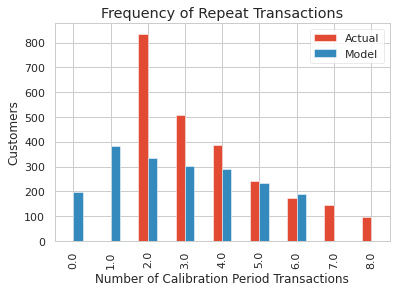

In [143]:
plot_period_transactions(bgf)
plt.show()

In [144]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.80, q: 0.34, v: 3.73>

In [145]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

CustomerID
12415.0    5772.177098
12590.0    5029.408953
12435.0    4288.934927
12409.0    3918.807445
14088.0    3917.128538
18102.0    3870.996680
12753.0    3678.575902
14646.0    3605.309143
15749.0    3216.047938
14096.0    3196.435322
dtype: float64

In [146]:
cltv = ggf.customer_lifetime_value(bgf,cltv_df['frequency'],
                                   cltv_df['recency'],cltv_df['T'],
                                   cltv_df['monetary'],time=6,
                                   freq="W",discount_rate=0.01)

In [147]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,CustomerID,clv
1122,14646.0,108691.797610
2761,18102.0,92510.277355
843,14096.0,56135.699371
36,12415.0,53978.798679
1257,14911.0,53427.083011
2458,17450.0,53004.426445
874,14156.0,45708.064212
2487,17511.0,37047.559984
2075,16684.0,26217.822999
650,13694.0,25301.558007


In [148]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv[["clv"]])
cltv["scaled_clv"] = scaler.transform(cltv[["clv"]])

cltv["segment"] = pd.qcut(cltv["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv.head()

,CustomerID,clv,scaled_clv,segment
0,12347.0,2200.757812,0.020248,A
1,12348.0,1050.352232,0.009664,B
2,12352.0,1007.740705,0.009272,B
3,12356.0,2109.557658,0.019409,A
4,12358.0,1870.554771,0.017210,A


In [152]:
cltv.to_csv("customer_segmentation_result.csv")

In [156]:
import chart_studio.plotly as py

In [159]:
fig = make_subplots(rows=2,
                    cols=2,
                    subplot_titles=("A", "B",'C','D'))

fig.add_trace(go.Box(y =cltv[cltv['segment']=='A']['clv'],showlegend=False,
                     name = 'A',
                     marker_color='#1760E1'),row=1,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='B']['clv'],showlegend=False,
                     name = 'B',
                     marker_color='#1760E1'),row=1,col=2)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='C']['clv'],showlegend=False,
                     name = 'C',
                     marker_color='#1760E1'),row=2,col=1)
fig.add_trace(go.Box(y =cltv[cltv['segment']=='D']['clv'],showlegend=False,
                     name = 'D',
                     marker_color='#1760E1'),row=2,col=2)

fig.update_layout(title={'text': "CLTV by SEGMENTS",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  template='plotly')
#fig = go.Figure(data=data, layout=layout)      
iplot(fig)

In [151]:
data = go.Bar(x = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['segment'],
              y = cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],
              text = round(cltv.groupby('segment').agg({'clv':'mean'}).reset_index()['clv'],3),
              textposition= 'auto',
              marker = dict(color = 'darkorange'))

layout = go.Layout(title={'text': "Average CLV by Segments",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title='Segment'),
                   yaxis =dict(title='CLV'),
                   template = 'plotly_white')

fig=go.Figure(data=data, layout=layout)
fig.update_yaxes(range=[0,5100])
iplot(fig)